# Relevance feedback

In [1]:
import re, math
from collections import Counter
import nltk


# Assumption 1: We have the entire vocab for documents at least
# Assumption 2: Relevant and irrelevant documents were chosen by some method
# Assumption 3: User's intial query at least partially works
# Assumption 4: Term distribution of non-relevant documents are sufficiently distinct from relevant ones

query = "hello world"
relevant_documents = ["hello world retrieval hello", "hello world document aaryam"]
non_relevant_documents = ["aaryam", "tze guang kun is fab", "world is mine"]
universal_vocab = {"hello", "world", "retrieval", "document", "world", "is", "mine", "tze", "guang", "kun", "aaryam"}

ALPHA = 1
BETA = 0.75
GAMMA = 0.15 # Usually we don't allow non-ranked in calculations so set gamme value to 0
    
# Generate the table for doc or query with tf no idf
def generateTable (doc):
    words = nltk.word_tokenize(doc)
    table = Counter(nltk.word_tokenize(doc))
    vector = {}
    for term in universal_vocab:
        if (term in table):
            # TF no IDF
            vector[term] = 1 + math.log10(table[term])
        else:
            vector[term]= 0
        
    return vector


print (generateTable(relevant_documents[0]))

def getCentroid(docs_list):
    total_sum = {}
    # Sum up tf-idf of all docs for each word to find centroid
    for doc in docs_list:
        score_table = generateTable(doc)
        for term in score_table:
            if term in total_sum:
                total_sum[term] += score_table[term]
            else:
                total_sum[term] = score_table[term]
    
    centroid = {}
    for term in total_sum:
        centroid[term] = total_sum[term]/len(docs_list)
    
    return centroid

def getRocchio (original_query):
    original_query_space = generateTable(original_query)
    centroid_relevant = getCentroid(relevant_documents)
    centroid_non_relevant = getCentroid(non_relevant_documents)
    query_modified = {}
    for term in universal_vocab:
        query_modified[term] = ALPHA*original_query_space[term] + \
        BETA*centroid_relevant[term] - \
        GAMMA*centroid_non_relevant[term]
        
        # Set it to zero if it is negative, sometimes they can go to a negative value
        if (query_modified[term] < 0):
            query_modified[term] = 0
        
    return query_modified

print ("====================")

for term in sorted(getRocchio(query).items(), key = lambda kv:(kv[1], kv[0]), reverse=True):
    print (term)
# Now we can see the scores of some other terms which could make up the query too

{'guang': 0, 'mine': 0, 'aaryam': 0, 'tze': 0, 'kun': 0, 'document': 0, 'world': 1.0, 'retrieval': 1.0, 'is': 0, 'hello': 1.3010299956639813}
('hello', 1.862886248373993)
('world', 1.7)
('retrieval', 0.375)
('document', 0.375)
('aaryam', 0.325)
('tze', 0)
('mine', 0)
('kun', 0)
('is', 0)
('guang', 0)


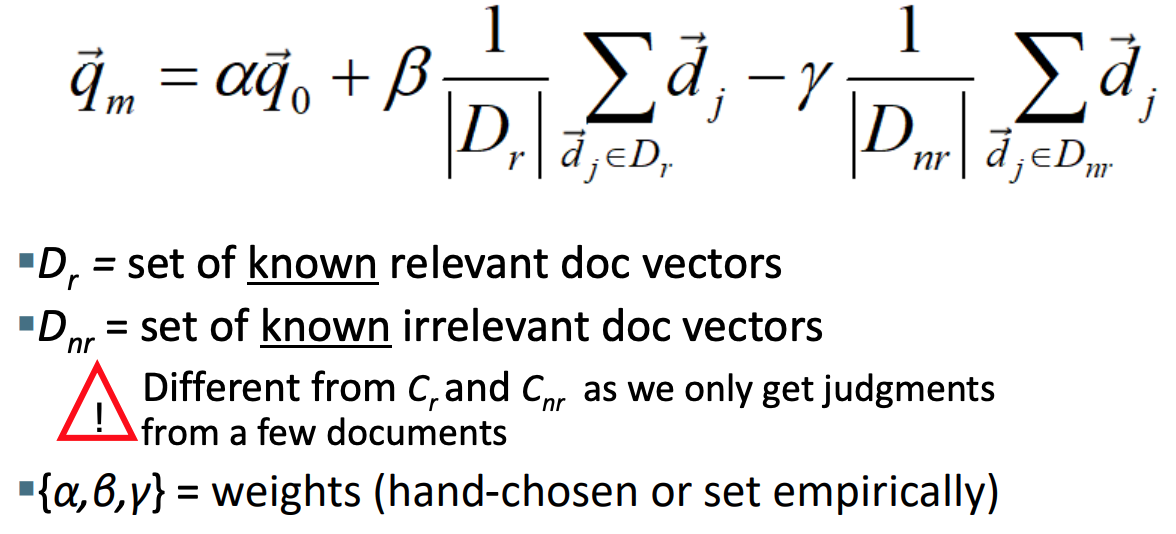

##### Effect of tuning gamma, alpha, beta
- Higher `BETA` and `GAMMA` if we want to trust the judged documents more - do so only if we have a lot of judged documents
- Higher `ALPHA` means we trust the query terms more
- Higher `BETA` than `GAMMA` means we favour more positive feedback, as it is more valuable than negative ones.

Common params: `ALPHA = 1`, `BETA = 0.75`, `GAMMA = 0.15`  
eg. `aaryam` has a **lower score** compared to `retrieval` and `document` as it is in the non relevant docs as well.

##### Further steps:

1. Queries which makes sense will then be parsed back to the query, yielding more documents
2. User will then decide what's relevant and what's not relevant again
3. Process will repeat


##### Pseudo Relevance feedback
Blind feedback means that we assume the top k documents are relevant. It works really well on average but can go horribly wrong for some queries.

# Thesaurus based query expansion

- For each term in a query, expand the query with synonyms and related words eg. feline -> cat
- Generally increases recall, but may decrease precision when terms are ambiguous

In [6]:
from nltk.corpus import wordnet as wn

print (wn.synsets("motorcar"))

[Synset('car.n.01')]


### Automatic thesaurus generation

- Generate thesaurus by analysing document
- Assumption: Distributional similarity
- i.e Two words are similar if they co-occur/ share same grammatical relations
Compute using term-term similarities

In [10]:
from nltk.book import text1

text1.similar("monstrous")

true contemptible christian abundant few part mean careful puzzled
mystifying passing curious loving wise doleful gamesome singular
delightfully perilous fearless


#### Problems
1. Term ambiguity may introduce irrelevant statistically correlated terms eg. Apple red fruit computer
2. False positives: Words deemed similar are not especially opposites
3. False negatives: Words deemed dissimilar that are similar

# Relevance feedback vs query expansion

In relevance feedback, additional input is given on documents which is used to reweight terms in the documents - suggest more appropriate terms to add based on Rocchio.  
  
In query expansion, additional input (good or bad) is given on words or phrases